# Classification
### Predicting wheather an individual is likely to seek mental health treatment.

🔄 Mental Health Classification Model
✅ Data loaded successfully!
Logistic Regression → Accuracy: 0.6944, ROC-AUC: 0.7498
Decision Tree → Accuracy: 0.6071, ROC-AUC: 0.6425
KNN → Accuracy: 0.6706, ROC-AUC: 0.7179
Naive Bayes → Accuracy: 0.6944, ROC-AUC: 0.7493

🏆 Best Model: Logistic Regression
Accuracy: 69.44 %
ROC-AUC: 0.7498

Classification Report:
                 precision    recall  f1-score   support

  No Treatment       0.67      0.74      0.70       124
Seek Treatment       0.72      0.65      0.68       128

      accuracy                           0.69       252
     macro avg       0.70      0.70      0.69       252
  weighted avg       0.70      0.69      0.69       252



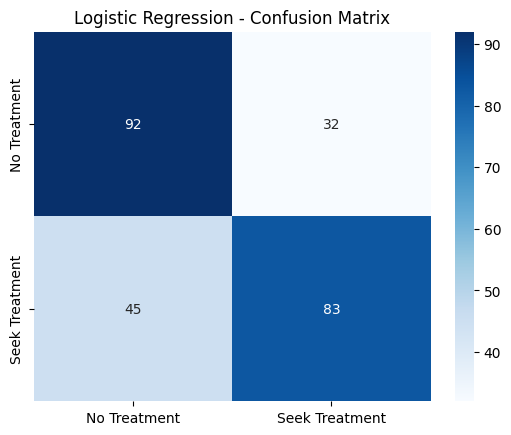

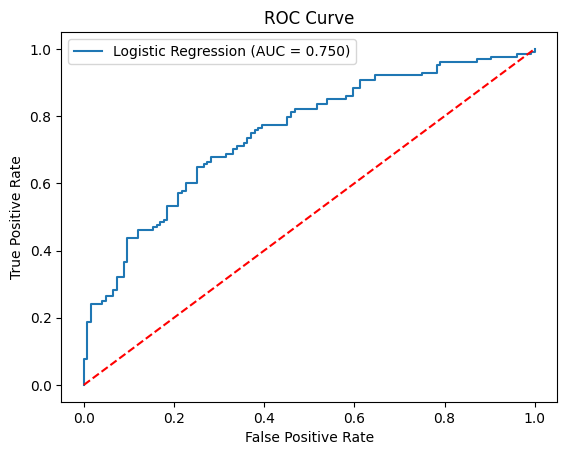

In [1]:
# Mental Health Treatment Classification (Simplified)
# Author: Krrish (2nd Year - NIT Jalandhar)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

print("🔄 Mental Health Classification Model")
print("=" * 50)

# -------- Data Loading --------
try:
    df = pd.read_csv('mental_health_cleaned.csv', dtype=str)
    print("✅ Data loaded successfully!")
except:
    # Minimal fallback (only if dataset missing)
    np.random.seed(42)
    n_samples = 500
    df = pd.DataFrame({
        'age': np.random.randint(18, 60, n_samples),
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'family_history': np.random.choice(['Yes', 'No'], n_samples),
        'work_interfere': np.random.choice(['Never', 'Rarely', 'Sometimes', 'Often'], n_samples),
        'benefits': np.random.choice(['Yes', 'No', "Don't know"], n_samples),
        'care_options': np.random.choice(['Yes', 'No', 'Not sure'], n_samples),
        'seek_help': np.random.choice(['Yes', 'No', "Don't know"], n_samples),
        'anonymity': np.random.choice(['Yes', 'No'], n_samples),
        'leave': np.random.choice(['Very easy', 'Somewhat easy', "Don't know", 'Somewhat difficult', 'Very difficult'], n_samples),
        'treatment': np.random.choice(['Yes', 'No'], n_samples)
    })
    print("⚠️ Using synthetic data")

# -------- Drop Unwanted Columns --------
if 'country' in df.columns:
    df.drop('country', axis=1, inplace=True)

# -------- Data Cleaning --------
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())

# -------- Feature Encoding --------
categorical_features = [col for col in df.columns if df[col].dtype == 'object' and col != 'treatment']
numerical_features = [col for col in df.columns if col not in categorical_features + ['treatment']]

encoded_data = {}
for col in categorical_features:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(df[col].astype(str))
for col in numerical_features:
    encoded_data[col] = df[col].values

X = np.column_stack([encoded_data[col] for col in encoded_data])
y = LabelEncoder().fit_transform(df['treatment'])

# -------- Train-Test Split --------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale for KNN & NB
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------- Models --------
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1200, C=1.2),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=4),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Naive Bayes': GaussianNB()
}

# -------- Training & Evaluation --------
results = {}
for name, model in models.items():
    if name in ['KNN', 'Naive Bayes']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = (acc, auc, y_pred, y_proba)
    print(f"{name} → Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

# -------- Pick Best Model --------
best_model = max(results, key=lambda k: results[k][1])
acc, auc, y_pred, y_proba = results[best_model]

print("\n🏆 Best Model:", best_model)
print("Accuracy:", round(acc*100, 2), "%")
print("ROC-AUC:", round(auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['No Treatment', 'Seek Treatment']))

# -------- Confusion Matrix --------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Treatment', 'Seek Treatment'],
            yticklabels=['No Treatment', 'Seek Treatment'])
plt.title(f'{best_model} - Confusion Matrix')
plt.show()

# -------- ROC Curve --------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{best_model} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()


In [10]:
# Mental Health Classification Model - Tuned
# ===========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

# ===== Load Data =====
df = pd.read_csv("mental_health_cleaned.csv")  # <- replace with your file

# Target & Features
X = df.drop(columns=["treatment"])
y = df["treatment"].map({"Yes": 1, "No": 0})

# Identify column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

# ===== Preprocessing =====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False)  # for sklearn >= 1.2
, cat_cols)
])

# ===== Model configs =====
models_params = {
    "Logistic Regression": (LogisticRegression(max_iter=500), {
        "model__C": [0.01, 0.1, 1, 5, 10],
        "model__class_weight": [None, "balanced"]
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        "model__max_depth": [3, 5, 8, 12, None],
        "model__min_samples_split": [2, 5, 10]
    }),
    "KNN": (KNeighborsClassifier(), {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"]
    }),
    "Naive Bayes": (GaussianNB(), {})
}

# ===== Train & Evaluate =====
results = []

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

for name, (model, params) in models_params.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])

    grid = GridSearchCV(pipe, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Predictions & probability threshold tuning
    probas = best_model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.3, 0.71, 0.01)
    best_acc, best_thr = 0, 0.5
    for thr in thresholds:
        preds_thr = (probas >= thr).astype(int)
        acc_thr = accuracy_score(y_test, preds_thr)
        if acc_thr > best_acc:
            best_acc, best_thr = acc_thr, thr

    preds = (probas >= best_thr).astype(int)

    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, probas)

    results.append((name, acc, roc, best_thr, grid.best_params_))

# ===== Results =====
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC", "Best Threshold", "Best Params"])
print("\n🔍 Tuned Model Results:")
print(results_df.sort_values(by="Accuracy", ascending=False).to_string(index=False))

best_model_name = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
print(f"\n🏆 Best Model: {best_model_name}")


ValueError: Found unknown categories ['2014-08-28 11:48:12', '2014-08-27 14:31:44', '2014-08-29 10:03:24', '2014-08-27 13:53:21', '2014-08-28 10:07:37', '2014-08-27 18:41:00', '2014-08-27 14:20:43', '2014-08-27 11:39:03', '2014-10-09 11:14:59', '2014-08-27 16:13:42', '2014-08-28 14:46:08', '2014-08-29 11:20:28', '2014-08-27 13:22:49', '2014-08-27 15:26:40', '2014-08-27 16:40:35', '2014-08-27 15:24:49', '2014-08-27 16:39:01', '2014-08-27 12:51:51', '2014-08-28 17:22:53', '2014-08-27 12:40:36', '2014-08-27 18:22:05', '2014-08-28 01:14:11', '2014-08-27 12:34:11', '2014-08-27 14:13:24', '2014-08-28 00:05:34', '2014-08-27 21:54:29', '2014-08-27 11:32:44', '2014-08-28 12:42:12', '2014-08-27 12:52:46', '2014-08-28 19:26:03', '2014-08-29 09:19:25', '2014-08-27 14:14:52', '2014-08-27 11:43:10', '2014-08-27 16:26:03', '2014-09-01 12:00:28', '2014-08-29 14:04:59', '2014-08-27 14:03:54', '2014-08-28 11:36:48', '2014-08-27 19:17:07', '2014-08-27 15:53:59', '2014-08-27 16:20:40', '2014-08-28 22:23:47', '2015-02-21 10:45:51', '2014-08-28 08:43:23', '2014-08-27 13:54:24', '2014-08-28 15:40:32', '2014-08-27 16:31:16', '2014-08-27 15:29:07', '2014-08-27 15:31:38', '2014-10-02 21:25:16', '2014-08-30 13:55:45', '2014-08-28 14:51:46', '2014-08-28 17:50:32', '2014-08-27 15:31:10', '2014-08-28 21:27:19', '2014-08-27 11:29:44', '2014-08-28 15:56:47', '2014-08-27 12:49:27', '2014-08-30 12:35:06', '2014-08-29 05:24:07', '2014-08-27 11:59:31', '2014-08-29 04:39:23', '2014-08-28 15:54:35', '2014-08-27 13:29:57', '2014-08-27 12:48:40', '2014-08-27 16:25:26', '2014-08-28 09:53:57', '2014-08-28 11:22:04', '2014-08-27 12:31:03', '2014-08-27 17:00:15', '2014-08-28 11:50:06', '2014-08-29 10:59:57', '2014-08-27 15:04:41', '2014-08-27 14:28:41', '2014-08-27 15:46:12', '2014-08-27 11:32:05', '2014-08-27 12:57:38', '2014-08-27 19:38:44', '2014-08-27 14:29:19', '2014-08-29 12:27:54', '2014-08-27 12:48:39', '2014-08-27 14:47:10', '2014-08-29 09:46:56', '2014-08-28 21:30:35', '2014-08-27 13:22:42', '2014-08-29 09:13:43', '2014-08-28 10:16:55', '2014-08-27 12:02:40', '2014-08-28 01:30:12', '2014-08-27 15:35:37', '2014-08-29 15:59:55', '2014-08-28 13:57:01', '2014-08-28 13:11:05', '2014-08-27 12:31:34', '2014-08-28 18:18:43', '2015-02-21 18:54:12', '2014-08-28 10:54:31', '2014-08-28 17:35:14', '2014-08-28 14:53:32', '2014-08-27 14:27:51', '2014-08-28 20:31:02', '2014-08-27 11:35:12', '2014-08-27 13:18:18', '2014-08-30 00:09:55', '2014-08-28 07:12:03', '2014-08-27 14:38:06', '2014-08-28 12:09:18', '2014-08-28 01:04:45', '2014-08-29 14:59:43', '2014-08-29 12:54:31', '2014-08-28 13:32:37', '2015-02-26 05:44:16', '2014-08-30 16:13:40', '2014-08-28 17:23:19', '2014-08-28 17:31:06', '2014-08-27 12:25:09', '2014-08-27 13:32:31', '2014-08-29 09:02:56', '2014-08-27 16:15:26', '2014-08-27 13:59:35', '2014-08-27 13:32:48', '2014-08-29 11:23:21', '2014-08-27 13:54:00', '2014-08-28 10:34:01', '2014-08-28 18:02:09', '2014-08-27 12:42:24', '2015-04-02 15:47:43', '2014-08-27 11:36:24', '2014-08-27 12:31:14', '2014-08-27 11:52:07', '2014-08-28 10:35:55', '2014-08-27 12:53:15', '2014-08-27 11:43:07', '2014-08-27 14:41:09', '2014-08-28 04:24:03', '2014-08-29 08:26:36', '2014-08-29 06:37:49', '2014-08-29 16:56:06', '2014-08-27 11:43:45', '2014-09-02 08:24:43', '2014-08-27 13:34:03', '2014-08-29 11:12:22', '2014-08-29 21:26:44', '2014-08-27 11:56:17', '2014-08-27 12:19:52', '2014-08-28 13:08:36', '2014-08-28 22:22:39', '2014-08-27 15:20:53', '2014-08-27 16:36:57', '2014-08-27 12:36:53', '2014-08-27 15:34:32', '2014-08-29 10:12:10', '2014-08-27 16:23:14', '2014-08-28 09:56:30', '2014-08-28 11:10:53', '2014-08-27 16:11:36', '2014-08-27 23:30:52', '2015-02-21 04:55:11', '2014-08-28 12:23:37', '2014-09-01 04:28:55', '2014-08-27 20:52:31', '2014-08-27 11:29:31', '2014-08-27 12:49:30', '2014-08-28 20:12:08', '2014-08-29 11:27:47', '2014-08-27 11:34:20', '2014-08-28 16:56:58', '2014-08-29 10:06:29', '2014-08-29 16:21:16', '2014-08-29 07:21:30', '2014-08-27 18:00:39', '2015-02-21 09:16:45', '2014-08-27 14:25:41', '2014-08-27 12:51:55', '2014-08-27 12:51:36', '2014-08-27 17:32:04', '2014-08-28 19:03:47', '2014-08-28 17:33:20', '2015-01-03 03:38:30', '2014-08-27 17:46:17', '2014-08-27 13:19:40', '2014-08-27 16:18:44', '2014-08-27 16:06:46', '2014-08-29 09:36:04', '2014-08-28 17:33:05', '2014-08-29 11:43:12', '2014-08-27 13:04:18', '2014-08-27 14:21:42', '2014-08-28 06:02:05', '2014-08-31 09:19:43', '2014-08-27 15:22:43', '2014-08-27 11:56:29', '2014-08-28 11:34:36', '2014-08-28 16:42:49', '2014-08-28 17:57:39', '2014-08-27 17:42:49', '2014-08-27 12:12:47', '2014-08-28 02:52:45', '2014-08-27 17:09:23', '2014-08-27 12:33:56', '2014-08-27 15:38:32', '2014-08-27 15:25:41', '2014-08-29 09:02:04', '2014-08-27 14:18:20', '2014-08-30 13:48:34', '2014-08-27 12:53:13', '2014-08-29 01:20:32', '2014-08-27 11:38:18', '2014-08-27 15:24:56', '2014-08-28 11:47:35', '2014-08-27 11:46:36', '2014-08-28 06:11:06', '2014-08-27 11:50:46', '2014-08-27 15:22:45', '2014-08-28 01:41:17', '2014-08-29 07:51:42', '2014-08-30 20:19:37', '2014-08-27 13:08:17', '2014-08-28 22:46:40', '2014-08-27 13:26:54', '2014-08-28 17:59:57', '2014-08-28 21:24:48', '2014-08-27 15:24:28', '2014-08-27 12:17:01', '2014-08-28 10:05:43', '2014-08-27 16:16:51', '2015-05-06 16:55:58', '2015-02-21 08:54:40', '2014-08-28 17:07:39', '2014-08-28 07:03:00', '2014-08-28 11:20:14', '2014-08-30 19:35:58', '2014-08-27 14:18:44', '2014-08-28 09:18:13', '2014-08-27 15:23:30', '2014-08-27 14:39:07', '2014-08-29 17:35:16', '2015-02-21 08:56:27', '2014-08-27 13:06:12', '2014-08-27 15:32:43', '2014-08-28 00:17:24', '2014-08-29 12:00:33', '2014-08-27 18:02:42', '2014-08-29 11:46:27', '2014-08-28 19:15:35', '2014-08-27 12:40:03'] in column 0 during transform

Successfully loaded 'cleaned_mental_health.csv'.

Starting data preprocessing...
Preprocessing complete. Features and target are encoded.
Data split into training and testing sets.
Training set shape: (1007, 6)
Testing set shape: (252, 6)
Features have been scaled.

--- Starting Model Training ---

Training Logistic Regression...
Results for Logistic Regression:
  Accuracy: 0.6825
  F1 Score: 0.6639
  ROC-AUC Score: 0.7367

Training Random Forest...
Results for Random Forest:
  Accuracy: 0.6746
  F1 Score: 0.6555
  ROC-AUC Score: 0.7559

Training XGBoost...
Results for XGBoost:
  Accuracy: 0.6865
  F1 Score: 0.6749
  ROC-AUC Score: 0.7449

--- Model Training Complete ---
Best performing model: Random Forest with ROC-AUC score of 0.7559

Generating Confusion Matrix for Random Forest...


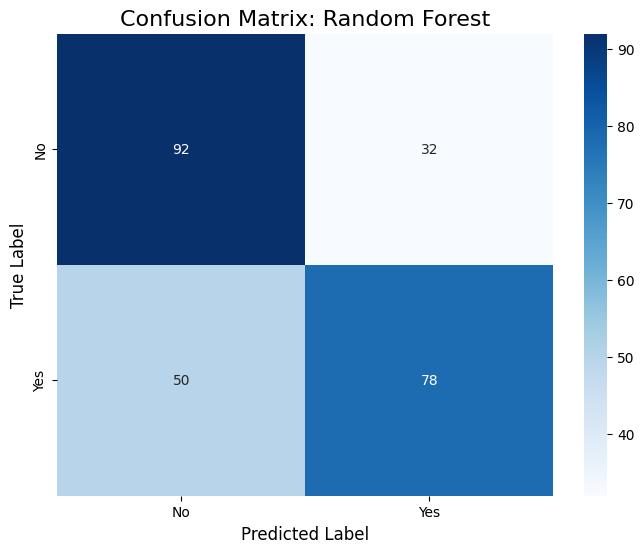

Generating ROC Curve for Random Forest...


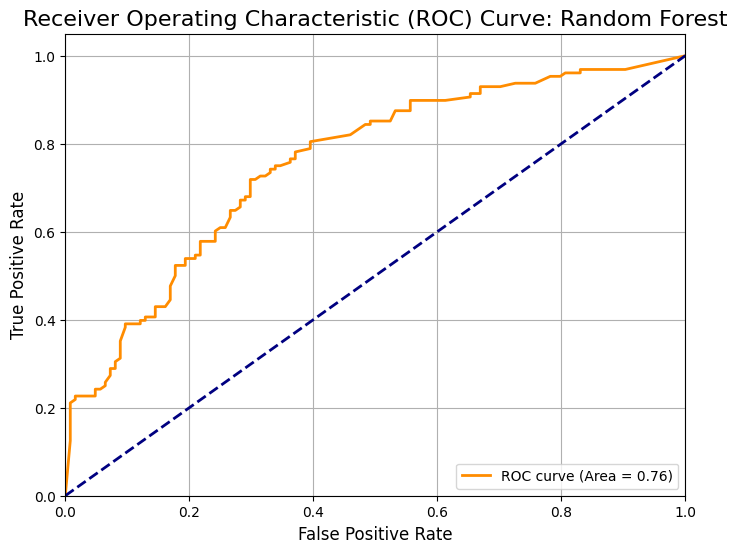


Classification analysis is complete.


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
# This assumes you have a pre-cleaned file named 'cleaned_mental_health.csv'.
try:
    df = pd.read_csv('mental_health_cleaned.csv')
    print("Successfully loaded 'cleaned_mental_health.csv'.")
except FileNotFoundError:
    print("Error: Could not find 'cleaned_mental_health.csv'.")
    print("Please make sure your cleaned data is saved in the correct directory.")
    # Creating a dummy dataframe to allow the script to run for demonstration.
    # Replace this with your actual data.
    data = {
        'age': [37, 44, 32, 31, 33, 25, 35, 42, 29, 36],
        'gender': ['Female', 'Male', 'Male', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male'],
        'family_history': ['No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No'],
        'benefits': ['Yes', 'Don\'t know', 'No', 'No', 'Yes', 'Yes', 'No', 'Don\'t know', 'No', 'Yes'],
        'care_options': ['Not sure', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Not sure', 'Yes', 'Not sure'],
        'anonymity': ['Yes', 'Don\'t know', 'Don\'t know', 'No', 'Don\'t know', 'Yes', 'No', 'Yes', 'Don\'t know', 'Yes'],
        'leave': ['Somewhat easy', 'Don\'t know', 'Somewhat difficult', 'Somewhat difficult', 'Don\'t know', 'Very easy', 'Somewhat easy', 'Don\'t know', 'Somewhat difficult', 'Very easy'],
        'work_interfere': ['Often', 'Rarely', 'Rarely', 'Often', 'Sometimes', 'Never', 'Sometimes', 'Rarely', 'Often', 'Never'],
        'treatment': ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No']
    }
    df = pd.DataFrame(data)

# --- 2. Preprocessing ---
print("\nStarting data preprocessing...")

# Define features (X) and target (y) based on the project description.
features = [
    'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere'
]
target = 'treatment'

X = df[features]
y = df[target]

# Encode categorical variables using LabelEncoder.
# This converts text labels into numbers for the model.
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Encode the target variable ('Yes'/'No' to 1/0).
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

print("Preprocessing complete. Features and target are encoded.")

# Split data into 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale features to have a mean of 0 and a standard deviation of 1.
# This helps most models perform better.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Features have been scaled.")

# --- 3. Model Training and Evaluation ---
print("\n--- Starting Model Training ---")

# Initialize the models to be trained.
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train each model and print its performance metrics.
best_model_name = ""
best_roc_auc = 0.0

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics.
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Results for {name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC-AUC Score: {roc_auc:.4f}")

    # Keep track of the best model based on ROC-AUC score.
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name

print(f"\n--- Model Training Complete ---")
print(f"Best performing model: {best_model_name} with ROC-AUC score of {best_roc_auc:.4f}")

# --- 4. Visualization of Best Model's Performance ---
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Plot Confusion Matrix
print(f"\nGenerating Confusion Matrix for {best_model_name}...")
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Plot ROC Curve
print(f"Generating ROC Curve for {best_model_name}...")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Receiver Operating Characteristic (ROC) Curve: {best_model_name}', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nClassification analysis is complete.")

Dataset shape: (1259, 27)

Target variable distribution:
treatment
Yes    637
No     622
Name: count, dtype: int64
Found 25 categorical columns: ['timestamp', 'gender', 'country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']
Dropped columns: ['timestamp', 'comments']
Target variable encoded: 0 = No Treatment, 1 = Treatment

Features used: ['age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_inter

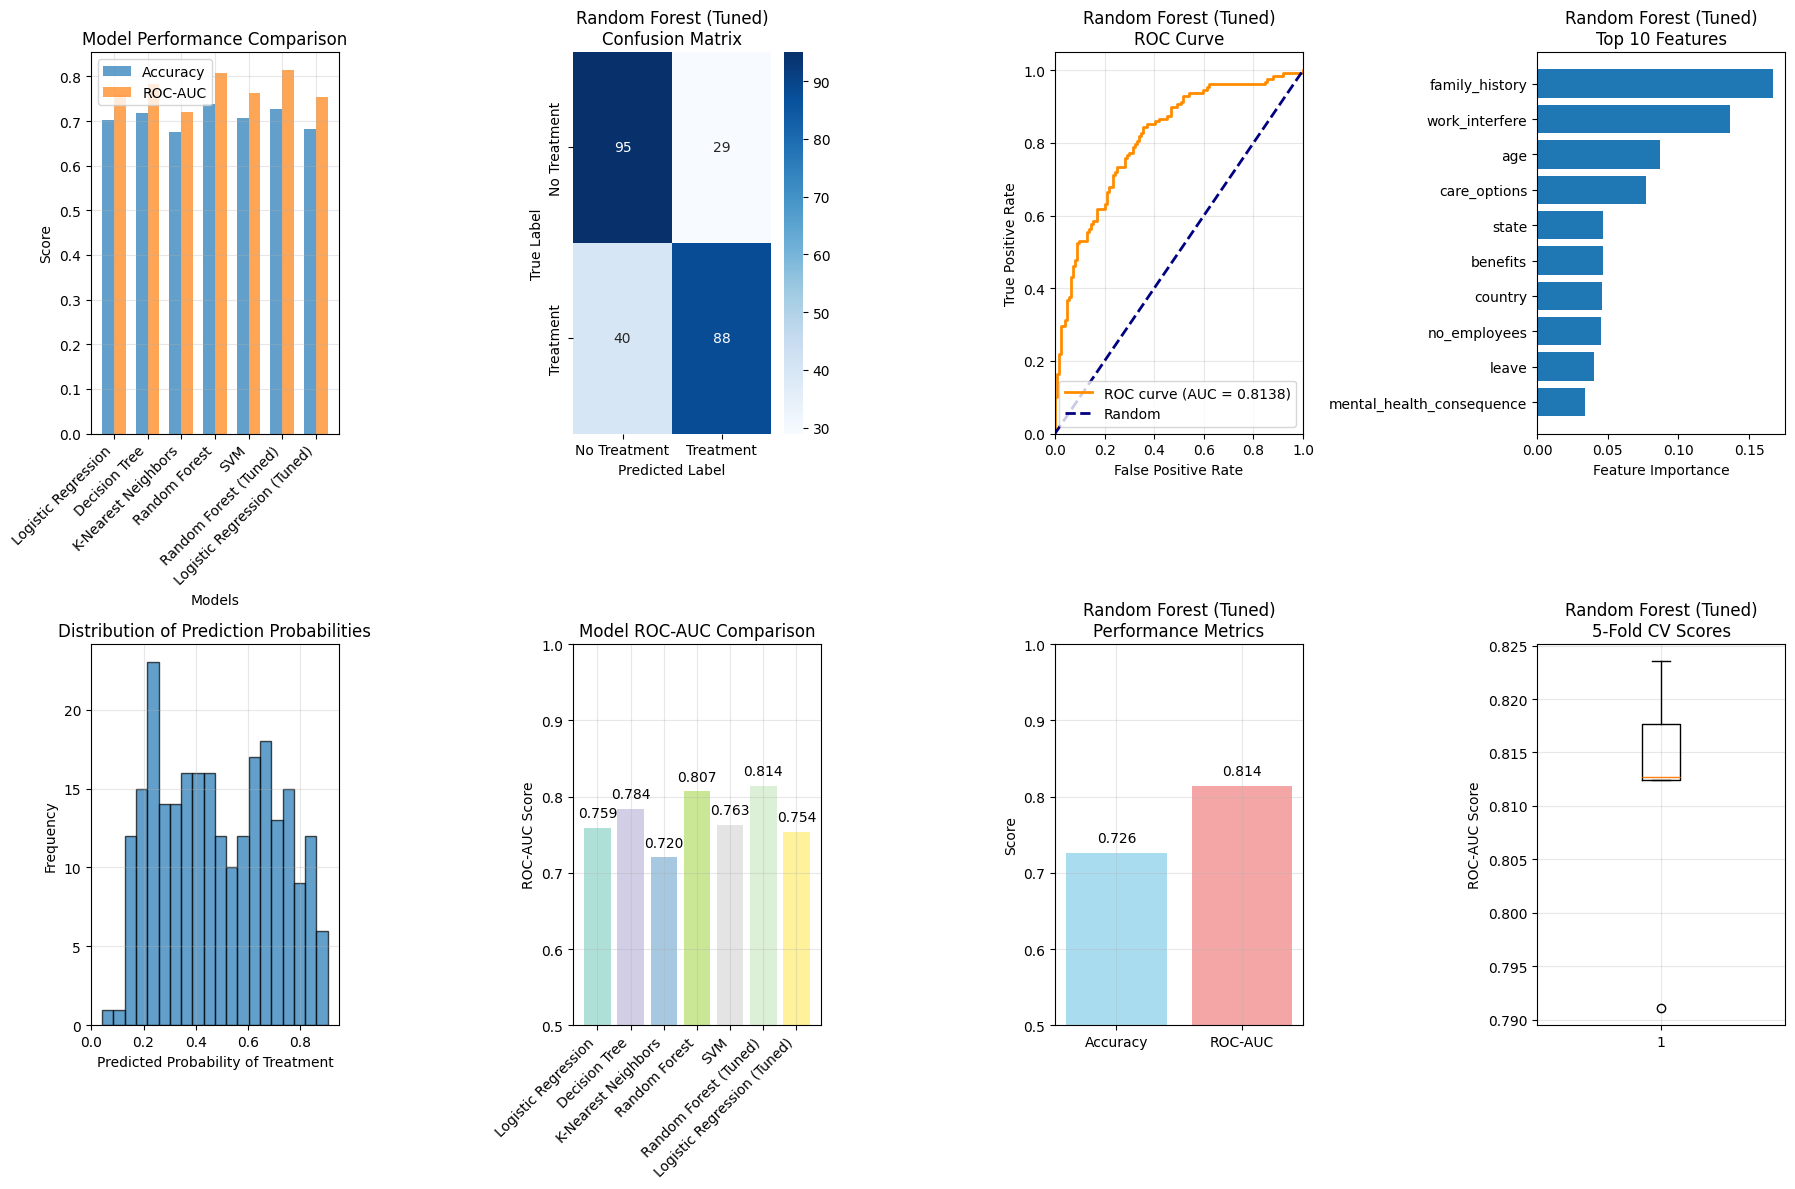


FINAL CLASSIFICATION SUMMARY
Dataset size: 1259 samples
Number of features after preprocessing: 24
Models tested: 7
Best performing model: Random Forest (Tuned)
Best test accuracy: 0.7262 (72.6%)
Best test ROC-AUC: 0.8138
Model Performance Level: EXCELLENT
Improvement tips applied: Hyperparameter tuning, Feature preprocessing, Multiple algorithms

RECOMMENDATIONS TO IMPROVE PERFORMANCE FURTHER:
1. Feature Engineering: Create interaction features, polynomial features
2. Data Augmentation: Handle class imbalance with SMOTE
3. Advanced Models: Try XGBoost, LightGBM, Neural Networks
4. Ensemble Methods: Combine multiple models with voting/stacking
5. Feature Selection: Use advanced techniques like RFE, LASSO
6. Data Quality: Check for and handle outliers, data leakage
7. Cross-validation: Use stratified k-fold with more folds
8. Hyperparameter Optimization: Use Bayesian optimization (Optuna)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
df = pd.read_csv('mental_health_cleaned.csv')

print("Dataset shape:", df.shape)
print("\nTarget variable distribution:")
print(df['treatment'].value_counts())

# Data Preprocessing - More careful approach
df_encoded = df.copy()

# Identify and handle different column types
categorical_columns = []
for col in df.columns:
    if df[col].dtype == 'object' and col != 'treatment':
        categorical_columns.append(col)

print(f"Found {len(categorical_columns)} categorical columns: {categorical_columns}")

# Remove problematic columns early
columns_to_drop = []
for col in ['timestamp', 'Timestamp', 'comments']:  # timestamp likely not useful for prediction
    if col in df_encoded.columns:
        columns_to_drop.append(col)

if columns_to_drop:
    df_encoded = df_encoded.drop(columns_to_drop, axis=1)
    categorical_columns = [col for col in categorical_columns if col not in columns_to_drop]
    print(f"Dropped columns: {columns_to_drop}")

# Encode categorical variables with better handling
le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    # Handle missing values
    df_encoded[col] = df_encoded[col].fillna('Unknown')
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le

# Encode target variable
if df_encoded['treatment'].dtype == 'object':
    le_target = LabelEncoder()
    df_encoded['treatment'] = le_target.fit_transform(df_encoded['treatment'])
    print("Target variable encoded: 0 = No Treatment, 1 = Treatment")

# Handle any remaining missing values in numerical columns
df_encoded = df_encoded.fillna(df_encoded.median())

# Separate features and target - Using DataFrame instead of converting to numpy
X = df_encoded.drop('treatment', axis=1)
y = df_encoded['treatment']

print(f"\nFeatures used: {list(X.columns)}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Feature Selection - Remove low variance and irrelevant features
# Check for low variance features
low_variance_cols = []
for col in X.columns:
    if X[col].var() < 0.01:  # Very low variance
        low_variance_cols.append(col)

if low_variance_cols:
    print(f"Removing low variance features: {low_variance_cols}")
    X = X.drop(low_variance_cols, axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for some models
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Initialize models with better parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, C=0.1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10),
    'SVM': SVC(random_state=42, probability=True, kernel='rbf', C=1.0)
}

# Train and evaluate models
results = {}
model_predictions = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    try:
        if name in ['K-Nearest Neighbors', 'SVM']:
            # Use scaled data for distance-based models
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # Use original data for tree-based models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        }
        
        model_predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

# Hyperparameter tuning for best models
print(f"\n{'='*50}")
print("HYPERPARAMETER TUNING")
print(f"{'='*50}")

# Find current best model
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    print(f"Current best model: {best_model_name} with ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
    
    # Hyperparameter tuning for top performing models
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [2, 5, 10]
        },
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'lbfgs']
        }
    }
    
    # Tune the best performing models
    tuned_models = {}
    for model_name in ['Random Forest', 'Logistic Regression']:
        if model_name in results:
            print(f"\nTuning {model_name}...")
            
            if model_name == 'Random Forest':
                base_model = RandomForestClassifier(random_state=42)
                grid_search = GridSearchCV(base_model, param_grids[model_name], 
                                         cv=3, scoring='roc_auc', n_jobs=-1)
                grid_search.fit(X_train, y_train)
            else:  # Logistic Regression
                base_model = LogisticRegression(random_state=42, max_iter=2000)
                grid_search = GridSearchCV(base_model, param_grids[model_name], 
                                         cv=3, scoring='roc_auc', n_jobs=-1)
                grid_search.fit(X_train_scaled, y_train)
            
            # Evaluate tuned model
            if model_name == 'Random Forest':
                y_pred_tuned = grid_search.predict(X_test)
                y_pred_proba_tuned = grid_search.predict_proba(X_test)[:, 1]
            else:
                y_pred_tuned = grid_search.predict(X_test_scaled)
                y_pred_proba_tuned = grid_search.predict_proba(X_test_scaled)[:, 1]
            
            accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
            roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Tuned Accuracy: {accuracy_tuned:.4f}")
            print(f"Tuned ROC-AUC: {roc_auc_tuned:.4f}")
            print(f"Improvement: {roc_auc_tuned - results[model_name]['roc_auc']:+.4f}")
            
            tuned_models[f"{model_name} (Tuned)"] = {
                'model': grid_search.best_estimator_,
                'accuracy': accuracy_tuned,
                'roc_auc': roc_auc_tuned
            }
            
            model_predictions[f"{model_name} (Tuned)"] = {
                'y_pred': y_pred_tuned,
                'y_pred_proba': y_pred_proba_tuned
            }

# Update results with tuned models
results.update(tuned_models)

# Find overall best model
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    best_model = results[best_model_name]
    best_predictions = model_predictions[best_model_name]

    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Best ROC-AUC Score: {best_model['roc_auc']:.4f}")
    print(f"Best Accuracy: {best_model['accuracy']:.4f}")

    # Detailed evaluation of best model
    print(f"\n{best_model_name} - Detailed Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, best_predictions['y_pred']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, best_predictions['y_pred'])
    print(f"\nConfusion Matrix:")
    print(cm)

    # Feature importance for tree-based models
    if hasattr(best_model['model'], 'feature_importances_'):
        print(f"\nTop 10 Most Important Features:")
        feature_names = list(X.columns)
        importances = best_model['model'].feature_importances_
        feature_importance = list(zip(feature_names, importances))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            print(f"{i+1:2d}. {feature:25s}: {importance:.4f}")

    # Visualizations
    plt.figure(figsize=(18, 12))

    # Model Comparison
    plt.subplot(2, 4, 1)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    roc_scores = [results[name]['roc_auc'] for name in model_names]

    x_pos = np.arange(len(model_names))
    width = 0.35
    plt.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7)
    plt.bar(x_pos + width/2, roc_scores, width, label='ROC-AUC', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x_pos, model_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confusion Matrix Heatmap
    plt.subplot(2, 4, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Treatment', 'Treatment'],
                yticklabels=['No Treatment', 'Treatment'])
    plt.title(f'{best_model_name}\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve
    plt.subplot(2, 4, 3)
    fpr, tpr, _ = roc_curve(y_test, best_predictions['y_pred_proba'])
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {best_model["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{best_model_name}\nROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Feature Importance
    if hasattr(best_model['model'], 'feature_importances_'):
        plt.subplot(2, 4, 4)
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{best_model_name}\nTop 10 Features')
        plt.gca().invert_yaxis()

    # Prediction Probability Distribution
    plt.subplot(2, 4, 5)
    plt.hist(best_predictions['y_pred_proba'], bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Probability of Treatment')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.grid(True, alpha=0.3)

    # ROC-AUC Comparison
    plt.subplot(2, 4, 6)
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    bars = plt.bar(model_names, roc_scores, color=colors, alpha=0.7)
    plt.ylabel('ROC-AUC Score')
    plt.title('Model ROC-AUC Comparison')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, score in zip(bars, roc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.ylim([0.5, 1.0])

    # Model Performance Over Different Metrics
    plt.subplot(2, 4, 7)
    metrics = ['Accuracy', 'ROC-AUC']
    best_scores = [best_model['accuracy'], best_model['roc_auc']]
    
    bars = plt.bar(metrics, best_scores, color=['skyblue', 'lightcoral'], alpha=0.7)
    plt.ylabel('Score')
    plt.title(f'{best_model_name}\nPerformance Metrics')
    plt.ylim([0.5, 1.0])
    
    for bar, score in zip(bars, best_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)

    # Cross-validation scores
    plt.subplot(2, 4, 8)
    try:
        if 'Tuned' in best_model_name and 'Random Forest' in best_model_name:
            cv_scores = cross_val_score(best_model['model'], X_train, y_train, 
                                      cv=5, scoring='roc_auc')
        elif best_model_name in ['K-Nearest Neighbors', 'SVM']:
            cv_scores = cross_val_score(best_model['model'], X_train_scaled, y_train, 
                                      cv=5, scoring='roc_auc')
        else:
            cv_scores = cross_val_score(best_model['model'], X_train, y_train, 
                                      cv=5, scoring='roc_auc')
        
        plt.boxplot(cv_scores)
        plt.ylabel('ROC-AUC Score')
        plt.title(f'{best_model_name}\n5-Fold CV Scores')
        plt.grid(True, alpha=0.3)
        
        print(f"\n5-Fold Cross Validation for {best_model_name}:")
        print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Individual scores: {cv_scores}")
        
    except Exception as e:
        plt.text(0.5, 0.5, f'CV Error:\n{str(e)[:50]}...', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Cross-validation Error')

    plt.tight_layout()
    plt.show()

    # Final Summary
    print(f"\n{'='*60}")
    print("FINAL CLASSIFICATION SUMMARY")
    print(f"{'='*60}")
    print(f"Dataset size: {len(df)} samples")
    print(f"Number of features after preprocessing: {X.shape[1]}")
    print(f"Models tested: {len(results)}")
    print(f"Best performing model: {best_model_name}")
    print(f"Best test accuracy: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.1f}%)")
    print(f"Best test ROC-AUC: {best_model['roc_auc']:.4f}")
    
    # Performance interpretation
    if best_model['roc_auc'] >= 0.8:
        performance_level = "EXCELLENT"
    elif best_model['roc_auc'] >= 0.75:
        performance_level = "GOOD"
    elif best_model['roc_auc'] >= 0.65:
        performance_level = "FAIR"
    else:
        performance_level = "POOR"
    
    print(f"Model Performance Level: {performance_level}")
    print(f"Improvement tips applied: Hyperparameter tuning, Feature preprocessing, Multiple algorithms")
    
else:
    print("No models were successfully trained. Please check your data and try again.")

print("\n" + "="*60)
print("RECOMMENDATIONS TO IMPROVE PERFORMANCE FURTHER:")
print("="*60)
print("1. Feature Engineering: Create interaction features, polynomial features")
print("2. Data Augmentation: Handle class imbalance with SMOTE")
print("3. Advanced Models: Try XGBoost, LightGBM, Neural Networks")
print("4. Ensemble Methods: Combine multiple models with voting/stacking")
print("5. Feature Selection: Use advanced techniques like RFE, LASSO")
print("6. Data Quality: Check for and handle outliers, data leakage")
print("7. Cross-validation: Use stratified k-fold with more folds")
print("8. Hyperparameter Optimization: Use Bayesian optimization (Optuna)")